In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline

# Toxic Comment Classification

## Libraries

+ nltk
+ pandas
+ scipy
+ numpy
+ matplotlib
+ wordcloud
+ sklearn

In [2]:
import re
import string

import nltk
import pandas as pd
import scipy as sp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from utils import data_loader

np.random.seed(0)

<IPython.core.display.Javascript object>

In [3]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaomingzhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yaomingzhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<IPython.core.display.Javascript object>

In [4]:
TRAIN_FILE = "data/train.csv"
TEST_FILE = "data/test.csv"
TEST_LABEL_FILE = "data/test_labels.csv"

<IPython.core.display.Javascript object>

In [5]:
train_df, valid_df = data_loader.load_train_data(TRAIN_FILE, valid_rate=0.25)
test_df = data_loader.load_test_data(TEST_FILE, TEST_LABEL_FILE)

<IPython.core.display.Javascript object>

## Data Exploration

In [6]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
130060,b7bf5a6846bd456a,"""\n Oppose. WP:MOSTM, the guideline covering t...",0,0,0,0,0,0
132921,c70efd55724be549,=== I AM GLEN AND I LOVE BEING A FAG===,1,0,0,0,0,0
46589,7c7f688f129e511e,"""\n\nIf it happens it may be worth noting but ...",0,0,0,0,0,0
129843,b68d08319e5fcb14,}}\n{{WikiProject Elections and Referendums,0,0,0,0,0,0
2528,06bf9f58011ca46a,"""\n\nI posted a thread about Donny on WP:ANI ...",0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [7]:
valid_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
56041,95bf7672a11f2799,Risk factors\n\nThe role of chlamydia should b...,0,0,0,0,0,0
90055,f0f3d0b835e0caae,Re your reversion of the removal of the websit...,0,0,0,0,0,0
86260,e6b38969b6d30127,But I do hate the_pope and think he I'd a pomp...,1,0,1,0,1,0
30981,524b653cc3469fe8,"""\nI am not interest in a Good Article """"revie...",0,0,0,0,0,0
8241,15e9e6b13c61af45,Hi again! I have added my image with appropria...,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [8]:
test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [9]:
COMMENT = "comment_text"
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

<IPython.core.display.Javascript object>

In [10]:
comment_lengths = train_df[COMMENT].str.len()
print("min length of comments: ", comment_lengths.min())
print("max length of comments: ", comment_lengths.max())
print("mean length of comments: ", comment_lengths.mean())

min length of comments:  6
max length of comments:  5000
mean length of comments:  393.94203492456427


<IPython.core.display.Javascript object>

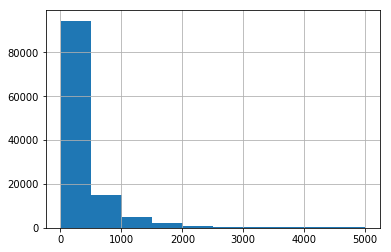

<IPython.core.display.Javascript object>

In [11]:
comment_lengths.hist()

In [12]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

<IPython.core.display.Javascript object>

### Distributions of Different Labels

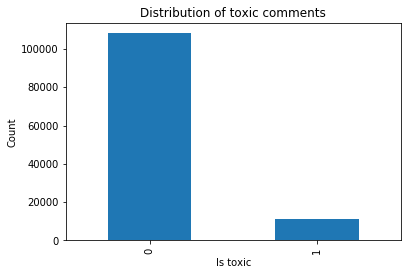

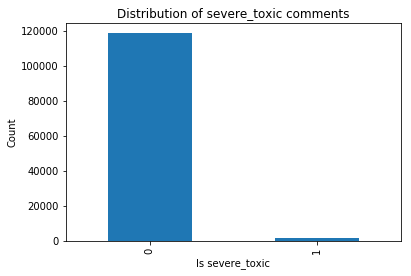

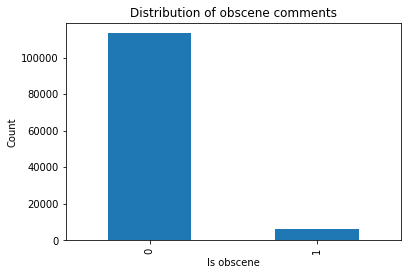

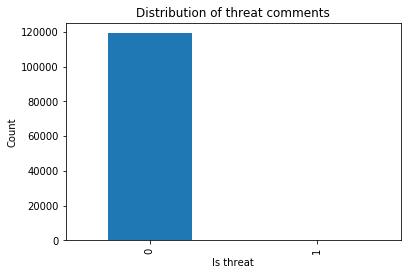

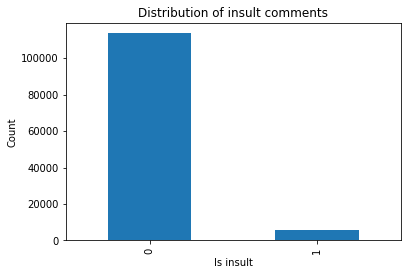

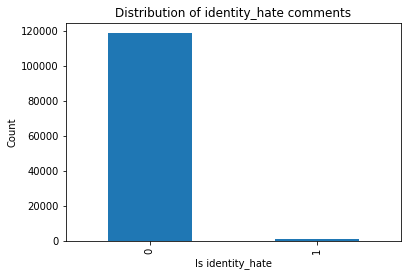

<IPython.core.display.Javascript object>

In [13]:
def show_column_distribution(labels):
    for label in labels:
        train_df[label].value_counts().plot.bar()
        plt.title("Distribution of %s comments" % label)
        plt.xlabel("Is %s" % label)
        plt.ylabel("Count")
        plt.show()


show_column_distribution(LABELS)

### Relationship between "Toxic" and other labels

In [14]:
def find_toxic_percentage(labels):
    for label in labels:
        df = train_df[train_df[label] == 1]
        percentage = (df[df["toxic"] == 1].shape[0] / df.shape[0]) * 100
        print("%.2f %% of %s comments are toxic" % (percentage, label))


find_toxic_percentage(LABELS)

100.00 % of toxic comments are toxic
100.00 % of severe_toxic comments are toxic
93.83 % of obscene comments are toxic
93.35 % of threat comments are toxic
93.59 % of insult comments are toxic
92.50 % of identity_hate comments are toxic


<IPython.core.display.Javascript object>

### Adding in new features and examine their relationships with toxicness

In [15]:
def strip_punctuations(s, replace=" "):
    s = s.translate(str.maketrans("", "", string.punctuation))
    return re.sub(r"\s+", replace, s)


def add_features(df):
    def count_caps_percentage(s):
        s = strip_punctuations(s, replace="")
        cnt = sum(1 for ch in s if ch.isupper())
        return 0 if cnt == 0 else int((cnt / len(s)) * 100)

    df["question_mark_count"] = df[COMMENT].apply(lambda s: s.count("?"))
    df["exclamation_mark_count"] = df[COMMENT].apply(lambda s: s.count("!"))
    df["caps_percentage"] = df[COMMENT].apply(count_caps_percentage)


add_features(train_df)

<IPython.core.display.Javascript object>

In [16]:
QUESTIONS = "question_mark_count"
EXCLAMATIONS = "exclamation_mark_count"
CAPS_PERCENTAGE = "caps_percentage"

FEATURES = [COMMENT, QUESTIONS, EXCLAMATIONS, CAPS_PERCENTAGE]

<IPython.core.display.Javascript object>

In [17]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,question_mark_count,exclamation_mark_count,caps_percentage
130060,b7bf5a6846bd456a,"""\n Oppose. WP:MOSTM, the guideline covering t...",0,0,0,0,0,0,0,0,8
132921,c70efd55724be549,=== I AM GLEN AND I LOVE BEING A FAG===,1,0,0,0,0,0,0,0,100
46589,7c7f688f129e511e,"""\n\nIf it happens it may be worth noting but ...",0,0,0,0,0,0,0,0,3
129843,b68d08319e5fcb14,}}\n{{WikiProject Elections and Referendums,0,0,0,0,0,0,0,0,11
2528,06bf9f58011ca46a,"""\n\nI posted a thread about Donny on WP:ANI ...",0,0,0,0,0,0,0,0,5


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


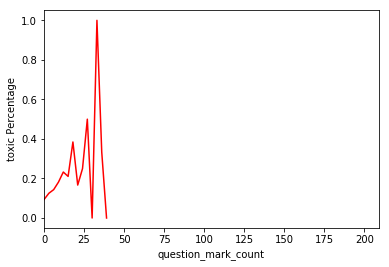

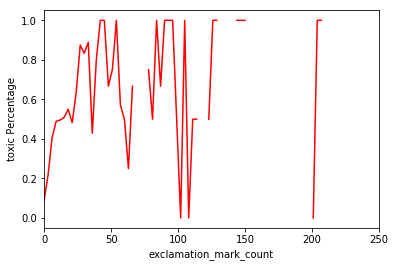

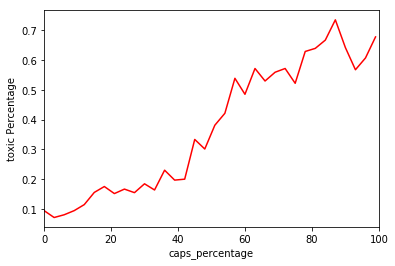

<IPython.core.display.Javascript object>

In [18]:
def plot_relationship(df, features, target):
    step = 3
    for i in range(1, len(features)):
        feature = features[i]
        x, y = [], []
        for n in range(df[feature].min(), df[feature].max() + 1, step):
            x.append(n)
            criteria = (df[feature] >= n) & (df[feature] < n + step)
            cnt = df[criteria].size
            toxic_cnt = df[(criteria) & (df[target] == 1)].size
            y.append(toxic_cnt / cnt)
        plt.plot(x, y, "r-")
        plt.xlabel(feature)
        plt.ylabel("%s Percentage" % target)
        # set xlim to 250 so that plot for exclamation_count won't be too large
        plt.xlim(0, min(250, df[feature].max()))
        plt.show()


plot_relationship(train_df, FEATURES, "toxic")

From the plots we can tell that `question_mark_count` and `caps_percentage` can be used to tell if a comment is toxic or not. No general trend has been found between toxicness and `exclamation_mark_count`.

### Cleaning Data

In [19]:
def transform_text(df):
    """
    Remove punctuations and stopwords from comment, and lemmatize words.
    """

    def clean(s, stop, lemmatizer):
        cleaned = [lemmatizer.lemmatize(w) for w in s.lower().split() if w not in stop]
        return " ".join(cleaned)

    cleaned = df.copy()
    cleaned[COMMENT] = cleaned[COMMENT].apply(strip_punctuations)
    stop = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    cleaned[COMMENT] = cleaned[COMMENT].apply(lambda s: clean(s, stop, lemmatizer))
    return cleaned


cleaned_df = transform_text(train_df)

<IPython.core.display.Javascript object>

In [20]:
cleaned_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,question_mark_count,exclamation_mark_count,caps_percentage
130060,b7bf5a6846bd456a,oppose wpmostm guideline covering trademark br...,0,0,0,0,0,0,0,0,8
132921,c70efd55724be549,glen love fag,1,0,0,0,0,0,0,0,100
46589,7c7f688f129e511e,happens may worth noting present view like adv...,0,0,0,0,0,0,0,0,3
129843,b68d08319e5fcb14,wikiproject election referendum,0,0,0,0,0,0,0,0,11
2528,06bf9f58011ca46a,posted thread donny wpani saturday 1 accused w...,0,0,0,0,0,0,0,0,5


<IPython.core.display.Javascript object>

### Checking what words have highest frequenct in toxic comments using WordCloud

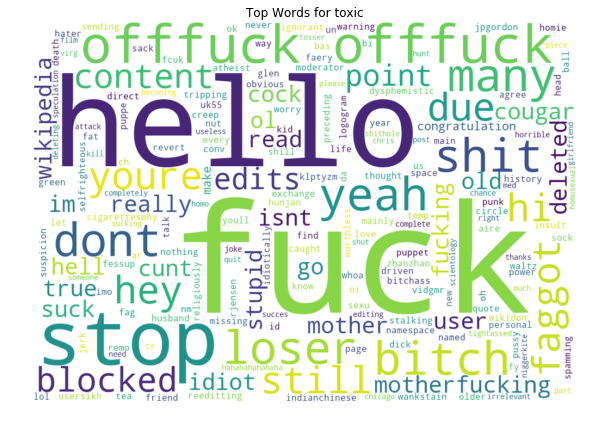

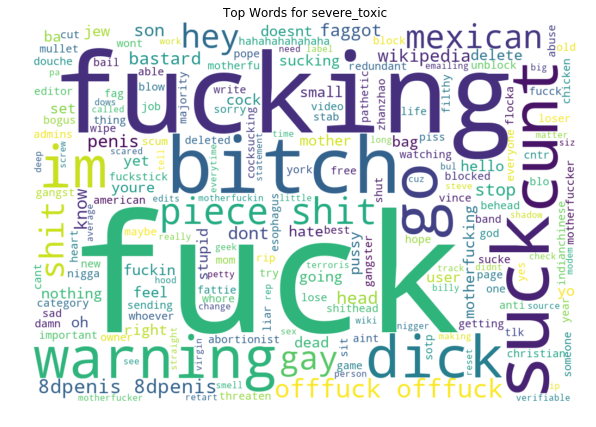

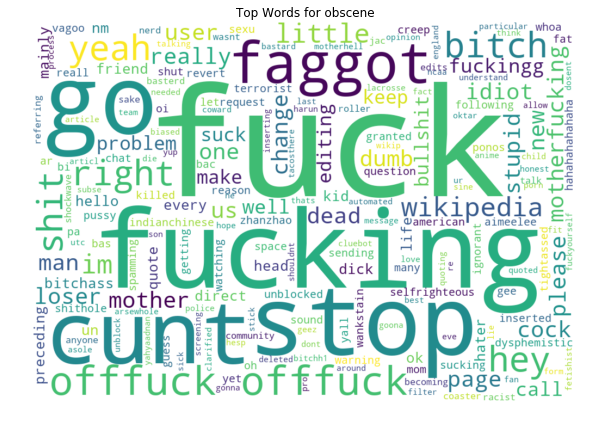

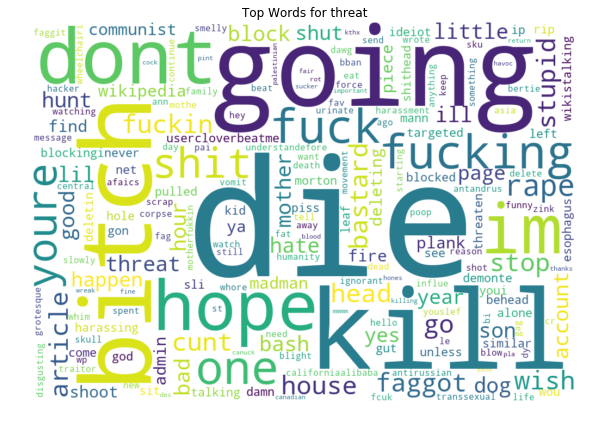

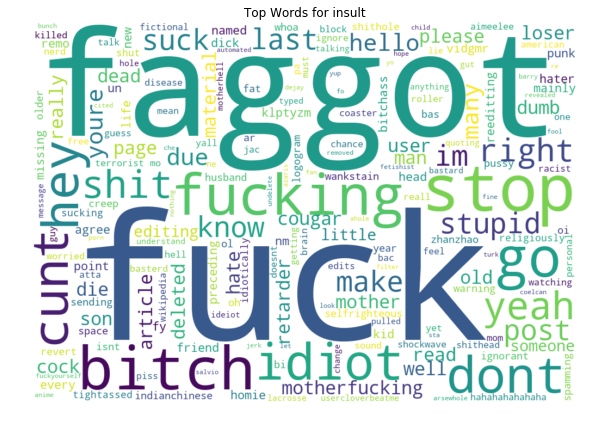

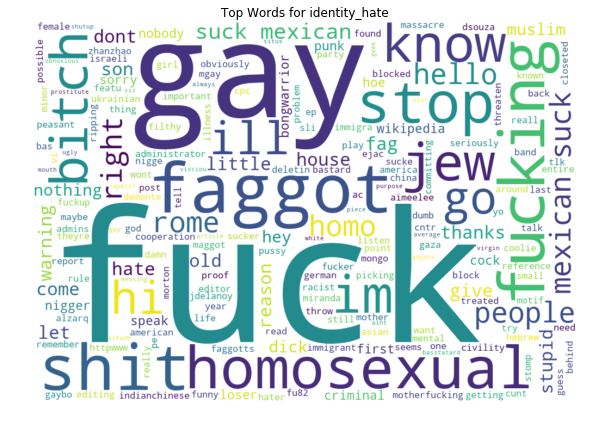

<IPython.core.display.Javascript object>

In [21]:
def generate_wordcloud(df, target):
    text = df[df[target] == 1][COMMENT]
    wordcloud = WordCloud(
        width=1000, height=700, background_color="white", stopwords=STOPWORDS
    ).generate(str(text))
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Top Words for %s" % target)
    plt.show()


for label in LABELS:
    generate_wordcloud(cleaned_df, label)

### Changing the comments into TF-IDF representation

In [22]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    strip_accents="unicode",
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    max_features=20000,  # setting max_features to 20000 made NB perform better
    token_pattern=r"(?u)\b\w*[a-zA-Z]\w*\b",
    stop_words="english",
)


def vectorize(df, vectorizer, test=False):
    if test:
        return vectorizer.transform(df[COMMENT])
    else:
        return vectorizer.fit_transform(df[COMMENT])

<IPython.core.display.Javascript object>

In [23]:
def preprocess(df, vectorizer, vec=False, test=False):
    add_features(df)
    df = transform_text(df)
    return vectorize(df, vectorizer, test) if vec else df


FEATURES = [QUESTIONS, EXCLAMATIONS, CAPS_PERCENTAGE]


def normalize(df):
    df = df / df.max(axis=0)
    return df


def preprocess_and_merge(df, vectorizer, test=False):
    word_vec = preprocess(df, vectorizer, vec=True, test=test)
    features = normalize(df[FEATURES])
    vec_df = sp.sparse.hstack((word_vec, features))
    return vec_df

<IPython.core.display.Javascript object>

In [24]:
train_vec = preprocess(train_df, vectorizer, vec=True, test=False)
valid_vec = preprocess(valid_df, vectorizer, vec=True, test=True)
test_vec = preprocess(test_df, vectorizer, vec=True, test=True)

<IPython.core.display.Javascript object>

## Training Models

We will use the following four models:

Baseline:
1. Naive-Bayes
2. Linear Regression

Advanced: 
1. Random forest
2. SVM

### Naive-Bayes Model with word vectors

#### Why Multinomial Bayes

> "The term Multinomial Naive Bayes simply lets us know that each 𝑝(𝑓𝑖|𝑐) is a multinomial distribution, rather than some other distribution. This works well for data which can easily be turned into counts, such as word counts in text."

In [25]:
def nb_predict(X, train_df, X_test, test_df, labels, alphas={}):
    preds = np.zeros((len(test_df), len(labels)))
    for i, target in enumerate(labels):
        alpha = alphas.pop(target, 1.0)
        print("[%s] predicting... Alpha = %.2f" % (target, alpha))
        clf = MultinomialNB(alpha=alpha)
        y = train_df[target].values
        clf.fit(X, y)
        preds[:, i] = clf.predict(X_test).transpose()
        mse = ((preds[:, i] - test_df[target]) ** 2).mean()
        score = metrics.accuracy_score(test_df[target], preds[:, i])
        print("[%s] pred: MSE = %.4f, Accuracy Score = %.4f\n" % (target, mse, score))
    return preds


# sample run on test set. Will use validation set later
nb_preds = nb_predict(train_vec, train_df, test_vec, test_df, LABELS)

[toxic] predicting... Alpha = 1.00
[toxic] pred: MSE = 0.0640, Accuracy Score = 0.9360

[severe_toxic] predicting... Alpha = 1.00
[severe_toxic] pred: MSE = 0.0056, Accuracy Score = 0.9944

[obscene] predicting... Alpha = 1.00
[obscene] pred: MSE = 0.0367, Accuracy Score = 0.9633

[threat] predicting... Alpha = 1.00
[threat] pred: MSE = 0.0033, Accuracy Score = 0.9967

[insult] predicting... Alpha = 1.00
[insult] pred: MSE = 0.0395, Accuracy Score = 0.9605

[identity_hate] predicting... Alpha = 1.00
[identity_hate] pred: MSE = 0.0109, Accuracy Score = 0.9891



<IPython.core.display.Javascript object>

#### Parameter Tuning (alpha for Laplace/Lidstone Smoothing) for Naive Bayes

[toxic] tuning alpha...


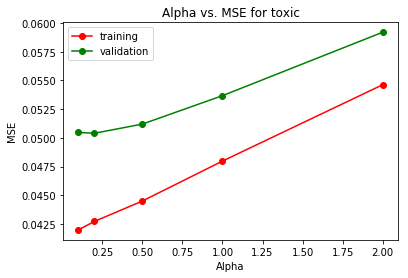

[severe_toxic] tuning alpha...


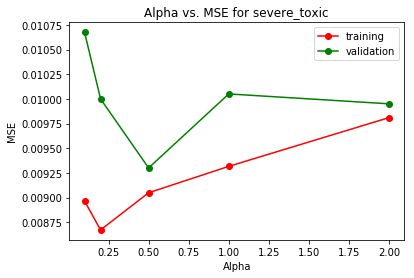

[obscene] tuning alpha...


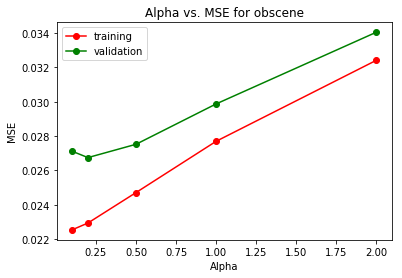

[threat] tuning alpha...


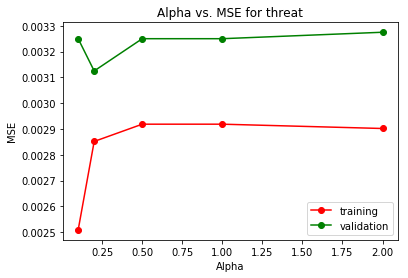

[insult] tuning alpha...


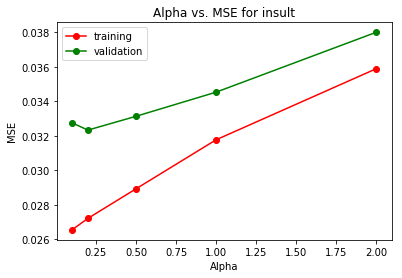

[identity_hate] tuning alpha...


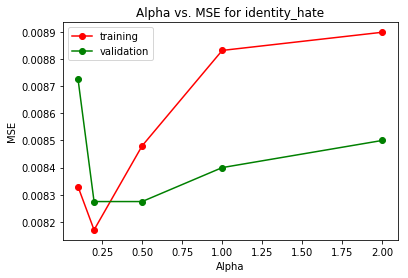

{'toxic': {'alpha': 0.2, 'accuracy': 0.9495987399684992},
 'severe_toxic': {'alpha': 0.5, 'accuracy': 0.9906997674941873},
 'obscene': {'alpha': 0.2, 'accuracy': 0.9732493312332808},
 'threat': {'alpha': 0.2, 'accuracy': 0.9968749218730468},
 'insult': {'alpha': 0.2, 'accuracy': 0.9676741918547964},
 'identity_hate': {'alpha': 0.2, 'accuracy': 0.991724793119828}}

<IPython.core.display.Javascript object>

In [26]:
alphas = [0.1, 0.2, 0.5, 1.0, 2.0]


def plot_mse(X, train_err, valid_err, name, target):
    plt.plot(X, train_err, "r-", label="training", marker="o")
    plt.plot(X, valid_err, "g-", label="validation", marker="o")
    plt.legend()
    plt.title("%s vs. MSE for %s" % (name, target))
    plt.xlabel(name)
    plt.ylabel("MSE")
    plt.show()


def tune_nb(alphas, X, train_df, X_val, valid_df, labels):
    def predict(clf, X, df, target):
        pred = clf.predict(X).transpose()
        mse = metrics.mean_squared_error(df[target], pred)
        return pred, mse

    preds, params = np.zeros((len(valid_df), len(labels))), {}
    for i, target in enumerate(labels):
        print("[%s] tuning alpha..." % target)
        y = train_df[target].values

        train_err, valid_err = [], []
        max_accuracy, best_alpha = 0.0, 0.0
        for alpha in alphas:
            clf = MultinomialNB(alpha=alpha)
            clf.fit(X, y)
            _, train_mse = predict(clf, X, train_df, target)
            p, valid_mse = predict(clf, X_val, valid_df, target)
            train_err.append(train_mse)
            valid_err.append(valid_mse)

            score = metrics.accuracy_score(valid_df[target], p)
            if score > max_accuracy:
                preds[:, i] = p
                max_accuracy = score
                best_alpha = alpha
        params[target] = {"alpha": best_alpha, "accuracy": max_accuracy}
        plot_mse(alphas, train_err, valid_err, "Alpha", target)
    return preds, params


_, nb_params = tune_nb(alphas, train_vec, train_df, valid_vec, valid_df, LABELS)
nb_params

No obvious overfitting or underfitting can be seen here. The lines look separate with each other because the MSEs are too small, so their differences are also tiny and the plots are "zoomed in", which made the gaps seem large. But in fact the training and validation MSEs are very similar.

However, we can tell that big alpha values yield higher errors. This is because if we smooth those unused words by too much, the results will be less accurate since we haven't learned whether those words are toxic or not.

In [27]:
def clean_nb_params(nb_params):
    params = {}
    for k, v in nb_params.items():
        params[k] = v["alpha"]
    return params


params = clean_nb_params(nb_params)

<IPython.core.display.Javascript object>

Using those parameters on the test set:

In [28]:
nb_preds = nb_predict(train_vec, train_df, test_vec, test_df, LABELS, params)

[toxic] predicting... Alpha = 0.20
[toxic] pred: MSE = 0.0676, Accuracy Score = 0.9324

[severe_toxic] predicting... Alpha = 0.50
[severe_toxic] pred: MSE = 0.0065, Accuracy Score = 0.9935

[obscene] predicting... Alpha = 0.20
[obscene] pred: MSE = 0.0379, Accuracy Score = 0.9621

[threat] predicting... Alpha = 0.20
[threat] pred: MSE = 0.0033, Accuracy Score = 0.9967

[insult] predicting... Alpha = 0.20
[insult] pred: MSE = 0.0405, Accuracy Score = 0.9595

[identity_hate] predicting... Alpha = 0.20
[identity_hate] pred: MSE = 0.0104, Accuracy Score = 0.9896



<IPython.core.display.Javascript object>

The above print results show our final test performance.

### SVM

In [29]:
merged_train = preprocess_and_merge(train_df, vectorizer, test=False)
merged_valid = preprocess_and_merge(valid_df, vectorizer, test=True)
merged_test = preprocess_and_merge(test_df, vectorizer, test=True)

<IPython.core.display.Javascript object>

In [40]:
def plot_coefficients(classifier, top_features=20):
    feature_names = vectorizer.get_feature_names()
    n = len(feature_names)
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    pos_coefs = [
        feature_names[i] if i < n else FEATURES[i % n - 1]
        for i in top_positive_coefficients
    ]
    neg_coefs = [
        feature_names[i] if i < n else FEATURES[i % n - 1]
        for i in top_negative_coefficients
    ]
    print("TOP POSITIVE FEATURES:\n", pos_coefs, "\n-----------")
    print("TOP NEGATIVE FEATURES:\n ", neg_coefs, "\n")

<IPython.core.display.Javascript object>

In [37]:
def svm_predict(X, train_df, X_test, test_df, labels, print_coefs=False):
    preds = np.zeros((len(test_df), len(labels)))
    clfs = {}
    for i, target in enumerate(labels):
        print("[%s] predicting..." % target)
        clf = LinearSVC(random_state=0, tol=1e-5)
        y = train_df[target].values
        clf.fit(X, y)
        preds[:, i] = clf.predict(X_test).transpose()
        mse = ((preds[:, i] - test_df[target]) ** 2).mean()
        score = metrics.accuracy_score(test_df[target], preds[:, i])
        clfs[target] = clf
        print("[%s] pred: MSE = %.4f, Accuracy Score = %.4f\n" % (target, mse, score))
        if print_coefs:
            plot_coefficients(clf)
    return preds, clfs

<IPython.core.display.Javascript object>

In [38]:
# sample run on test set. Will use validation set later
svm_preds, _ = svm_predict(train_vec, train_df, test_vec, test_df, LABELS)

[toxic] predicting...
[toxic] pred: MSE = 0.0741, Accuracy Score = 0.9259

[severe_toxic] predicting...
[severe_toxic] pred: MSE = 0.0072, Accuracy Score = 0.9928

[obscene] predicting...
[obscene] pred: MSE = 0.0375, Accuracy Score = 0.9625

[threat] predicting...
[threat] pred: MSE = 0.0035, Accuracy Score = 0.9965

[insult] predicting...
[insult] pred: MSE = 0.0399, Accuracy Score = 0.9601

[identity_hate] predicting...
[identity_hate] pred: MSE = 0.0097, Accuracy Score = 0.9903



<IPython.core.display.Javascript object>

In [41]:
svm_preds, clfs = svm_predict(
    merged_train, train_df, merged_test, test_df, LABELS, print_coefs=True
)

[toxic] predicting...
[toxic] pred: MSE = 0.0742, Accuracy Score = 0.9258

TOP POSITIVE FEATURES:
 ['dick', 'cocksucker', 'dumbass', 'nigger', 'faggot', 'moron', 'idiotic', 'fucker', 'crap', 'bastard', 'fucked', 'bitch', 'suck', 'bullshit', 'stupid', 'asshole', 'shit', 'idiot', 'fucking', 'fuck'] 
-----------
TOP NEGATIVE FEATURES:
  ['wikipedia little', 'touching', 'syndrome', 'montana', 'said youre', 'staff', 'reasonable', 'people really', 'redirect', 'certification', 'inspired', 'wee', 'know wikipedia', 'embarrassment', 'thank god', 'admire', 'lonely', 'abbey', 'casual', 'prejudiced'] 

[severe_toxic] predicting...
[severe_toxic] pred: MSE = 0.0069, Accuracy Score = 0.9931

TOP POSITIVE FEATURES:
 ['cancer', 'kill kill', 'uc', 'fuk', 'fuck bitch', 'fucking', 'eats shit', 'come say', 'chester', 'dont right', 'id love', 'motherfucker', 'wont tell', 'fuck', 'fing', 'hairy', 'rape', 'fcking', 'question_mark_count', 'youfuck'] 
-----------
TOP NEGATIVE FEATURES:
  ['faced', 'german', 'ir

<IPython.core.display.Javascript object>

SVC runs much faster after columns are normalized.

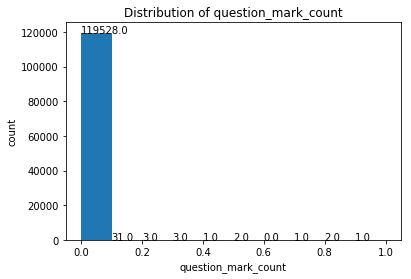

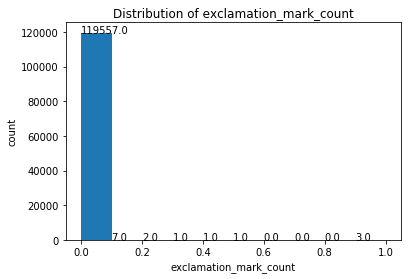

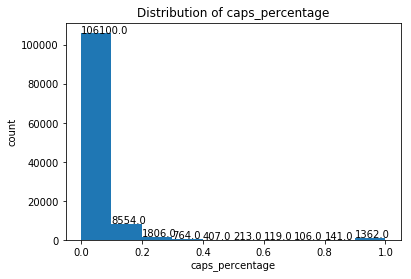

<IPython.core.display.Javascript object>

In [42]:
for col in FEATURES:
    c = normalize(train_df[col])
    arr = plt.hist(c)
    bins = len(arr[1])
    [plt.text(arr[1][i], arr[0][i], str(arr[0][i])) for i in range(bins - 1)]
    plt.title("Distribution of %s" % col)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

Most of our new features didn't help much here since most of them are zeros and therefore cannot provide too much information to our model.

> “Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes very well (look at the below snapshot).

https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72

In [44]:
def tune_svm(X, train_df, X_valid, valid_df, X_test, test_df, labels, Cs):
    clfs = {}
    for i, target in enumerate(labels):
        print("[%s] tuning C value..." % target)
        y, y_val = train_df[target].values, valid_df[target].values

        train_err, valid_err = [], []
        best_c, best_accuracy = 0.0, 0.0
        for c in Cs:
            clf = LinearSVC(random_state=0, max_iter=10000, C=c)
            clf.fit(X, y)
            train_preds = clf.predict(X).transpose()
            valid_preds = clf.predict(X_valid).transpose()

            train_mse = metrics.mean_squared_error(y, train_preds)
            valid_mse = metrics.mean_squared_error(y_val, valid_preds)
            train_err.append(train_mse)
            valid_err.append(valid_mse)

            score = metrics.accuracy_score(y_val, valid_preds)
            if score > best_accuracy:
                best_accuracy = score
                best_c = c
                clfs[target] = clf
        plot_mse(Cs, train_err, valid_err, "C value", target)

        y_test = test_df[target].values
        default_clf = LinearSVC()
        default_clf.fit(X, y)
        default_score = default_clf.score(X_test, y_test)
        tuned_score = clfs[target].score(X_test, y_test)
        print("[%s] Before Grid Search: test score = %.4f" % (target, default_score))
        print("[%s] After  Grid Search: test score = %.4f" % (target, tuned_score))
        print("[%s] Best C: %f\n" % (target, best_c))
    return clfs

<IPython.core.display.Javascript object>

[toxic] tuning C value...


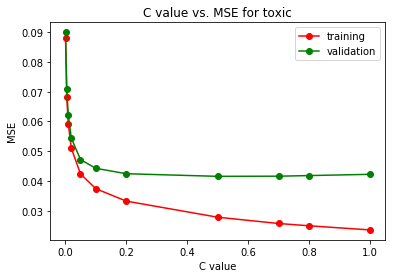

[toxic] Before Grid Search: test score = 0.9258
[toxic] After  Grid Search: test score = 0.9294
[toxic] Best C: 0.500000

[severe_toxic] tuning C value...


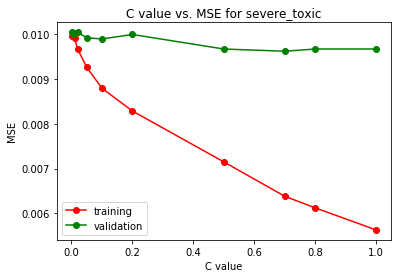

[severe_toxic] Before Grid Search: test score = 0.9931
[severe_toxic] After  Grid Search: test score = 0.9934
[severe_toxic] Best C: 0.700000

[obscene] tuning C value...


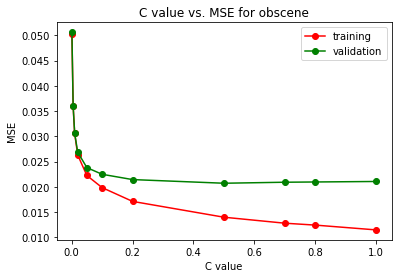

[obscene] Before Grid Search: test score = 0.9629
[obscene] After  Grid Search: test score = 0.9643
[obscene] Best C: 0.500000

[threat] tuning C value...


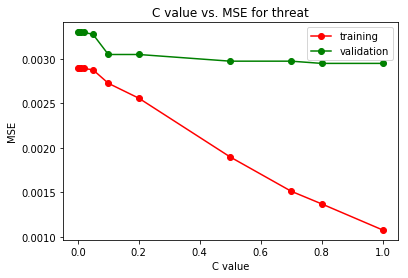

[threat] Before Grid Search: test score = 0.9965
[threat] After  Grid Search: test score = 0.9966
[threat] Best C: 0.800000

[insult] tuning C value...


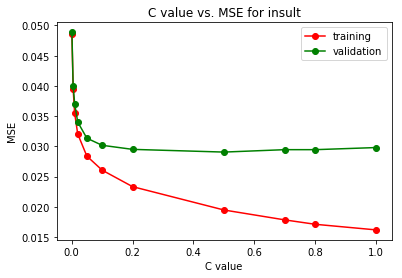

[insult] Before Grid Search: test score = 0.9600
[insult] After  Grid Search: test score = 0.9621
[insult] Best C: 0.500000

[identity_hate] tuning C value...


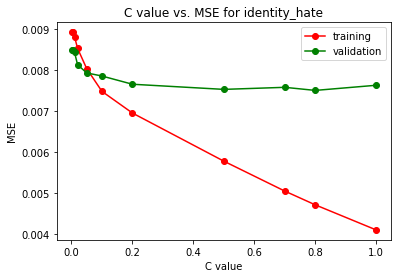

[identity_hate] Before Grid Search: test score = 0.9902
[identity_hate] After  Grid Search: test score = 0.9903
[identity_hate] Best C: 0.800000



<IPython.core.display.Javascript object>

In [45]:
Cs = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 1]

clfs = tune_svm(
    merged_train, train_df, merged_valid, valid_df, merged_test, test_df, LABELS, Cs
)

Tuning the C value gives us better prediction results, as we can see from the plots and print results. All C values are acceptable (no over-fitting or under-fitting again). Even though the C value for `threat` column seems to be over-fitting, it's still acceptable since the MSE values for training set and validation set are both really small.